In [1]:
import os
import sys

sys.path.append('..')
from pprint import pprint
import numpy as np
from dicomhd import io as dhd_io
from medpy.io import load as load_lbl
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


In [16]:
def extract_2D_patch(images, n_rows, n_cols, st):
    
    sizes=[1,n_rows, n_cols, 1] 
    strides=[1, int(n_rows/st), int(n_cols/st), 1]
    imgs = np.expand_dims(images, [-1])
    timgs = tf.convert_to_tensor(imgs, dtype='float32')
    tpatches = tf.image.extract_patches(timgs, 
                         sizes=sizes,
                         strides=strides,
                         rates=[1, 1, 1, 1],
                         padding='SAME')
    img_patches = tf.reshape(tpatches, (-1,n_rows, n_cols, 1))
    
    return img_patches

def extract_2D_patch_labels(tlbl_patches, ratio_th, n_rows, n_cols, method='ratio'):
    if method == 'max':
        t_patch_labels = tf.reduce_max(tlbl_patches, axis=[1,2,3])
    elif method == 'ratio':
        ratio_ann_voxels = tf.math.count_nonzero(tlbl_patches, axis=[1,2,3]) / (n_rows* n_cols)
        mask = ratio_ann_voxels < ratio_th
        t_patch_labels = tf.reduce_max(tlbl_patches, axis=[1,2,3])
        t_patch_labels = tf.where(mask, tf.zeros(tf.shape(t_patch_labels)), t_patch_labels)
    elif method == 'center':
        raise NotImplementedError
    else:
        raise ValueError('Invalid label extraction method!')
    
    return t_patch_labels


def extract_annotated_2D_patch(t_img_patches,t_lbl_patches, n_rows, n_cols, th):
    # get patch labels
    t_patch_labels = extract_2D_patch_labels(t_lbl_patches, th, n_rows, n_cols,'ratio')
    mask = t_patch_labels > 0
    t_lbl_patches_with_annotation = tf.boolean_mask(t_lbl_patches, mask, axis=0)
    t_patch_img_with_annotation = tf.boolean_mask(t_img_patches, mask, axis=0)
    t_patch_lbl_with_annotation = tf.boolean_mask(t_patch_labels, mask, axis = 0)
    return t_patch_img_with_annotation, t_lbl_patches_with_annotation, t_patch_lbl_with_annotation

def show_batch(image_batch, lbl_batch):
    plt.figure(figsize=(50, 50))
    for n in range(image_batch.shape[0]):
        ax = plt.subplot(10, 8, n+1 )
        plt.imshow(image_batch[n], cmap='gray')
        plt.imshow(lbl_batch[n],alpha=0.4)
        plt.axis("off")
        
def show_tf_batch(image_batch, lbl_batch, vis):
    plt.figure(figsize=(20, 20))
    for n in range(image_batch.shape[0]):
        ax = plt.subplot(6, 10, n+1 )
        plt.imshow(image_batch[n], cmap='gray')
        if vis:
            plt.imshow(lbl_batch[n],alpha=0.4)
        plt.axis("off")
        
def vis_2D_patch(
    lbl, 
    path_train_img,
    img_fname,
    st,
    th,
    visimg,
    visl, 
    n_rows,
    n_cols):
    
    if lbl.sum() > 0:
        if 'groundglass' in img_fname:
            mask = lbl==1
            lbl[mask] = 3
        # get indices for voxels with ann
        idx_with_ann = np.ma.where(lbl.sum(axis=(1,2)) > 0)[0]
    #     print(len(idx_with_ann))
        # crop label
        lbl_ann = lbl[idx_with_ann, ...]
        print(lbl_ann.shape)
         # load image
        img_file_path = os.path.join(path_train_img, img_fname)
        img = dhd_io.read_series(img_file_path)
        # crop image
        img_ann=img.pixel_data[idx_with_ann, ...]
        if visimg:
            show_batch(img_ann, lbl_ann)
        # extract patch
        lbl_patches = extract_2D_patch(lbl_ann, n_rows, n_cols, st)
        img_patches = extract_2D_patch(img_ann, n_rows, n_cols, st)
        t_patch_labels = extract_2D_patch_labels(lbl_patches, th, n_rows, n_cols)
        t_patch_img_with_annotation, t_lbl_patches_with_annotation, t_patch_lbl_with_annotation=\
        extract_annotated_2D_patch(img_patches,lbl_patches, n_rows, n_cols, th)
        print(t_lbl_patches_with_annotation.shape)
        show_tf_batch(t_patch_img_with_annotation[1:5,...,0].numpy(),
                          t_lbl_patches_with_annotation[1:5,...,0].numpy(),
                          visl)
        print('label for these patches are:', t_patch_lbl_with_annotation.numpy().max())
#     return


# Ground Glass

(44, 512, 512)
(10, 32, 32, 1)
label for these patches are: 3.0


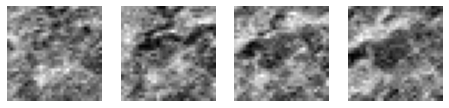

In [23]:
with tf.device('/cpu:0'):
    # path to data
    path_train_img = '../../data/val/input/complete/'
    path_train_lbl = '../../data/val/output/complete/'
    img_fname = 'groundglass-5ff7d9-Samir-2_reviewed_1-131'
    lbl_fname = 'groundglass-5ff7d9-Samir-2_reviewed_1-259'
    lbl_file_path = os.path.join(path_train_lbl, lbl_fname)
    lbl_file_path = os.path.join(lbl_file_path, 'annotation.gipl')
    lbl, label_header = load_lbl(lbl_file_path)
    lbl = np.swapaxes(lbl,0,2)
    vis_2D_patch(lbl,
                 path_train_img,
                 img_fname,
                 st=1,
                 th=0.8,
                 n_rows=32,
                 n_cols=32,
                 visimg=0,
                 visl=0
                )


In [20]:
mask = lbl==1
lbl[mask] = 3
lbl.max()

3

# Reticular

(35, 512, 512)
(60, 32, 32, 1)
label for these patches are: 4.0


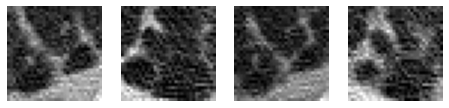

In [20]:
with tf.device('/cpu:0'):
    path_train_img = '../../data/val/input/complete/'
    path_train_lbl = '../../data/val/output/complete/'
    img_fname = 'Reticular-5e51ab-Samir_reviewed_1-509'
    lbl_fname = 'Reticular-5e51ab-Samir_reviewed_1-560'
    lbl_file_path = os.path.join(path_train_lbl, lbl_fname)
    lbl_file_path = os.path.join(lbl_file_path, 'annotation.gipl')
    lbl, label_header = load_lbl(lbl_file_path)
    lbl = np.swapaxes(lbl,0,2)
    vis_2D_patch(lbl,
             path_train_img,
             img_fname,
             st=1,
             th=0.6,
             n_rows=32,
             n_cols=32,
             visimg=0,
             visl=0
            )

# Normal

(66, 512, 512)
(1595, 32, 32, 1)
label for these patches are: 1.0


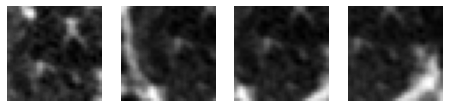

In [32]:
with tf.device('/cpu:0'):
    path_train_img = '../../data/val/input/complete/'
    path_train_lbl = '../../data/val/output/complete/'
    img_fname = 'Normal-0c9fab-Joe_reviewed_1-766'
    lbl_fname = 'Normal-0c9fab-Joe_reviewed_1-827'
    lbl_file_path = os.path.join(path_train_lbl, lbl_fname)
    lbl_file_path = os.path.join(lbl_file_path, 'annotation.gipl')
    lbl, label_header = load_lbl(lbl_file_path)
    lbl = np.swapaxes(lbl,0,2)
    vis_2D_patch(lbl,
             path_train_img,
             img_fname,
             st=4,
             th=0.5,
             n_rows=32,
             n_cols=32,
             visimg=0,
             visl=0
            )

# Hyperlucent

(25, 512, 512)
(15, 32, 32, 1)
label for these patches are: 2.0


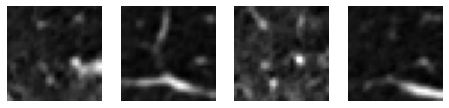

In [35]:
with tf.device('/cpu:0'):
    path_train_img = '../../data/val/input/complete/'
    path_train_lbl = '../../data/val/output/complete/'
    img_fname = 'Hyperlucent-1c9f8d-Samir_reviewed_1-663'
    lbl_fname = 'Hyperlucent-1c9f8d-Samir_reviewed_1-716'
    lbl_file_path = os.path.join(path_train_lbl, lbl_fname)
    lbl_file_path = os.path.join(lbl_file_path, 'annotation.gipl')
    lbl, label_header = load_lbl(lbl_file_path)
    lbl = np.swapaxes(lbl,0,2)
    vis_2D_patch(lbl,
                 path_train_img,
                 img_fname,
                 st=1,
                 th=0.9,
                 n_rows=32,
                 n_cols=32,
                 visimg=0,
                 visl=0
                )

# Honeycomb

(42, 512, 512)
(8, 32, 32, 1)
label for these patches are: 5.0


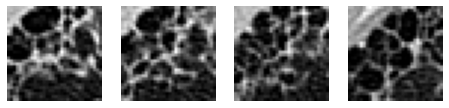

In [49]:
with tf.device('/cpu:0'):

    path_train_img = '../../data/val/input/complete/'
    path_train_lbl = '../../data/val/output/complete/'
    img_fname = 'Honeycomb-068c5d-Samir_reviewed_1-320'
    lbl_fname = 'Honeycomb-068c5d-Samir_reviewed_1-368'
    lbl_file_path = os.path.join(path_train_lbl, lbl_fname)
    lbl_file_path = os.path.join(lbl_file_path, 'annotation.gipl')
    lbl, label_header = load_lbl(lbl_file_path)
    lbl = np.swapaxes(lbl,0,2)
    vis_2D_patch(lbl,
                 path_train_img,
                 img_fname,
                 st=1,
                 th=0.6,
                 n_rows=32,
                 n_cols=32,
                 visimg=0,
                 visl=0
                )

(26, 512, 512)
(2, 32, 32, 1)
label for these patches are: 5.0


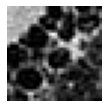

In [52]:
with tf.device('/cpu:0'):

    path_train_img = '../../data/val/input/complete/'
    path_train_lbl = '../../data/val/output/complete/'
    img_fname = 'Honeycomb-068c5d-Joe_reviewed_1-281'
    lbl_fname = 'Honeycomb-068c5d-Joe_reviewed_1-446'
    lbl_file_path = os.path.join(path_train_lbl, lbl_fname)
    lbl_file_path = os.path.join(lbl_file_path, 'annotation.gipl')
    lbl, label_header = load_lbl(lbl_file_path)
    lbl = np.swapaxes(lbl,0,2)
    vis_2D_patch(lbl,
                 path_train_img,
                 img_fname,
                 st=1,
                 th=0.5,
                 n_rows=32,
                 n_cols=32,
                 visimg=0,
                 visl=0
                )

# Consolidation

(15, 512, 512)
(9, 32, 32, 1)
label for these patches are: 6.0


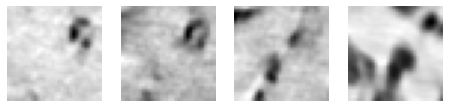

In [55]:
with tf.device('/cpu:0'):

    path_train_img = '../../data/val/input/complete/'
    path_train_lbl = '../../data/val/output/complete/'
    img_fname = 'consolidation-000063-Samir_reviewed_1-1024'
    lbl_fname = 'consolidation-000063-Samir_reviewed_1-1104'
    lbl_file_path = os.path.join(path_train_lbl, lbl_fname)
    lbl_file_path = os.path.join(lbl_file_path, 'annotation.gipl')
    lbl, label_header = load_lbl(lbl_file_path)
    lbl = np.swapaxes(lbl,0,2)
    vis_2D_patch(lbl,
                 path_train_img,
                 img_fname,
                 st=1,
                 th=0.7,
                 n_rows=32,
                 n_cols=32,
                 visimg=0,
                 visl=0
                )